# Why 'A' in Deep Learning Stands for the Awesome Adam Optimizer

The Adam optimizer, along with its different flavours, are arguably the most popular and effective optimizers in deep learning today. The optimizer is a combination of 2 equations which significantly advanced the vanilla SGD: momentum and RMSProp. In this article, we'll cover how the 2 equations come together to make the Adam optimizer. I wrote about both the equations in previous posts, so if you need a refresher on them or this is the first time you're hearing about them, then I highly suggest [my article on momentum](https://cutt.ly/cg2ai-momentum-medium) and [my other article on RMSProp](https://cutt.ly/cg2ai-rmsprop-medium). I cover both equations in extensive detail in those posts.

To continue with Adam; when going over momentum's and RMSProp's implementations, something you probably realized is that momentum replaces the gradient (i.e., the numerator), while RMSProp divides the gradient (i.e., the denominator). If you combine them both (see figure below), you now have momentum as the numerator and RMSProp as the denominator. This now becomes the equation for adaptive momentum estimation, also known as Adam. What I'm essentially saying is that if you've gone over my previous posts on [momentum](https://cutt.ly/cg2ai-momentum-medium) and [RMSProp](https://cutt.ly/cg2ai-rmsprop-medium), then you almost know all of Adam and you can easily skim through the rest of this post.

<img src="images/adam%20equations.PNG?raw=true"  width="600" height="600">

## Establishing Our Benchmark

Like always, better then explaining just with words, let's take a look at how to implement the Adam optimizer from scratch, with the help of PyTorch.

First thing first, let's import the relevant packages for this lesson.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Now, we're going to need some data. Like the previous posts, we'll use some mock data that we'll generate. It's sufficient to demonstrate Adam and how it compares to vanilla SGD. So let's come up with some data and, with the help of PyTorch's Dataset and DataLoader, create our dataset.

In [ ]:
dim = 1000
X = torch.randn((dim,dim), dtype=float)
y = torch.cat((torch.zeros(dim//2, dtype=float), torch.ones(dim//2, dtype=float)))

class ExampleDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len


data = ExampleDataset(X, y)
data_loader = DataLoader(dataset=data, batch_size=64, shuffle=True)

Now we're ready to create our model architecture. Just as the previous articles, it'll consist of 1 hidden layer which is half the size of input layer.

In [ ]:
class Model(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.hidden_layer = nn.Linear(dim, dim//2)
        self.last_layer = nn.Linear(dim//2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        out = self.sigmoid(self.hidden_layer(X))
        out = self.sigmoid(self.last_layer(out))
        return out

Let's initiate our model, set the number of epochs we'll train for along with the learning rate. Something else you'll see is a variable by the name of print_iter. The variable is just to print the loss at every 20 epochs (I use it multiple places in this article, hence the variable).

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 200
print_iter = 20
learning_rate = 1e-5

model = Model(dim).to(device)
bce = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

It's time train our vanilla SGD to set a benchmark.

In [ ]:
epoch_loss = []
model.train()
for epoch in range(epochs+1):
    iteration_loss = 0.
    for i, data in enumerate(data_loader):
        X, y = data
        y_pred = model(X.float().to(device))
        loss = bce(y_pred.to(device), y.reshape(-1,1).float().to(device))
        iteration_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss.append(iteration_loss/(i+1))
    if(epoch % print_iter == 0):
        print('Train: epoch: {0} - loss: {1:.5f}'.format(epoch, epoch_loss[-1]))

Train: epoch: 0 - loss: 0.72450
Train: epoch: 20 - loss: 0.71801
Train: epoch: 40 - loss: 0.71395
Train: epoch: 60 - loss: 0.71068
Train: epoch: 80 - loss: 0.70823
Train: epoch: 100 - loss: 0.70526
Train: epoch: 120 - loss: 0.70404
Train: epoch: 140 - loss: 0.70200
Train: epoch: 160 - loss: 0.69992
Train: epoch: 180 - loss: 0.69825
Train: epoch: 200 - loss: 0.69813


Let's plot it out.

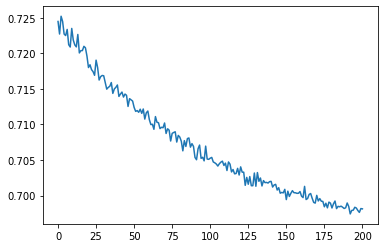

In [ ]:
plt.plot(epoch_loss)

The curve isn't really smooth. It's accompanied by many bumps, but it's our benchmark.

## Adam Optimizer from Scratch

Now it's time for the Adam optimizer. We'll use the same learning rate, epochs and architecture from above, but we'll set 2 more variables – our momentum and RMSProp values. We'll set them to the recommended values, which are 0.9 and 0.999 respectively.

In [ ]:
model = Model(dim).to(device)
bce = nn.BCELoss()
# we'll reuse the learning_rate variable from above
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
momentum = 0.9
rmsprop = 0.999

Let's train our model. Just as we did in the momentum and RMSProp lessons, we'll access SGD's param names to update them according to the Adam implementation (I explain params extensively in [my weight decay post](https://cutt.ly/cg2ai-weight-decay-medium), in case you need a refresher).

In [ ]:
epoch_loss = []
momentum_vals = {}
rmsprop_vals = {}
iteration = 1

model.train()
for epoch in range(epochs+1):
    iteration_loss = 0.
    for i, data in enumerate(data_loader):
        X, y = data
        y_pred = model(X.float().to(device))
        loss = bce(y_pred.to(device), y.reshape(-1,1).float().to(device))
        iteration_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        for name, w in model.named_parameters():
            if name not in momentum_vals:
                momentum_vals[name] = torch.zeros_like(w.grad).detach()
                rmsprop_vals[name] = torch.zeros_like(w.grad).detach()

            #momentum*gradients + (1-momentum)*gradients
            momentum_vals[name].mul_(momentum).add_(w.grad, alpha=1 - momentum)
            #rmsprop*gradients + (1-rmsprop)*gradients**2
            rmsprop_vals[name].mul_(rmsprop).addcmul_(w.grad, w.grad, value=1 - rmsprop)

            #bias correction
            m_bias_correction = 1 - momentum**iteration
            r_bias_correction = 1 - rmsprop**iteration          

            #momentum update step
            w.grad = momentum_vals[name]/m_bias_correction
            #rmsprop update step
            w.grad.divide_(torch.sqrt(rmsprop_vals[name]/r_bias_correction)) 
    optimizer.step()
    iteration += 1
      

    epoch_loss.append(iteration_loss/(i+1))
    if(epoch % print_iter == 0):
        print('Train: epoch: {0} - loss: {1:.5f}'.format(epoch, epoch_loss[-1]))

Train: epoch: 0 - loss: 0.70315
Train: epoch: 20 - loss: 0.66631
Train: epoch: 40 - loss: 0.63974
Train: epoch: 60 - loss: 0.61420
Train: epoch: 80 - loss: 0.58909
Train: epoch: 100 - loss: 0.56423
Train: epoch: 120 - loss: 0.53887
Train: epoch: 140 - loss: 0.51529
Train: epoch: 160 - loss: 0.49054
Train: epoch: 180 - loss: 0.46696
Train: epoch: 200 - loss: 0.44573


The results are significantly better. Let's plot it out and see how it performed.

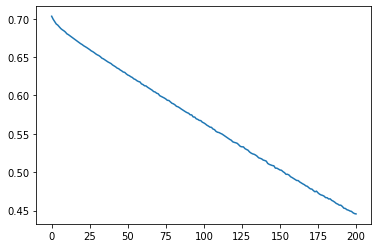

In [ ]:
plt.plot(epoch_loss)

That's an immense improvement. A good exercise would be to see how Adam stacks up against momentum and RMSProp. If you try it outside of this article, you should see it to be quite an improvement relative to when using either of them alone.

## Bias Correction Explained

Before we move on, if you've gone over my [momentum](https://cutt.ly/cg2ai-momentum-medium) and [RMSProp](https://cutt.ly/cg2ai-rmsprop-medium) posts, you probably noticed a difference. The first difference is that the 1-momentum isn't used in practice for when implementing momentum, but it is for its implementation in Adam. The second difference is the bias correction equations we've put in place for both momentum and RMSProp. They're essentially the same equation, minus for momentum we used the momentum value and for RMSProp we used it's respective value, but they're essentially identical.

The equation for momentum's bias correction equation is the following: <br/>
*momentum/(1 - momentum**iteration)*

Let's go over it in a little more detail. If you remember from [the momentum post](https://cutt.ly/cg2ai-momentum-medium), we mentioned that, for example, if our slope looks like this:

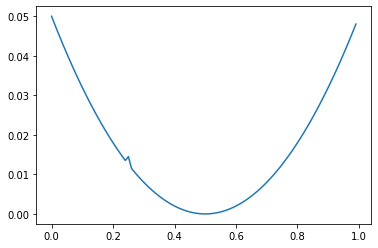

In [2]:
X = torch.arange(0,1,1e-2)
y = 0.2*((X-0.5)**2)
y[25] = y[25]+2e-3

plt.plot(X, y)

Momentum comes and makes the slope appear to look like this:

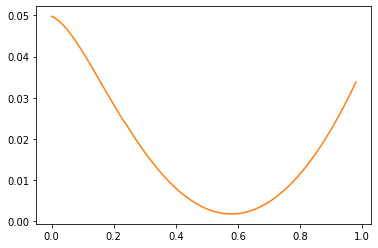

In [3]:
def gradient(x1, x2, y1, y2):
    return ((y2-y1)/(x2-x1)).item()

new_y = []
velocity = 0
momentum=0.9

for i in range(len(X)-1):
    cur_grad = gradient(X[i], X[i+1], y[i], y[i+1])
    velocity = (momentum*velocity) + ((1-momentum)*cur_grad)
    if(not new_y):
        prev_y = y[0]
    else:
        prev_y = new_y[-1]
    new_y.append((velocity*(X[i+1]-X[i]))+prev_y)

plt.plot(X[:-1], new_y, c='C1')

When we put those 2 plots above side-by-side, this is what we get:

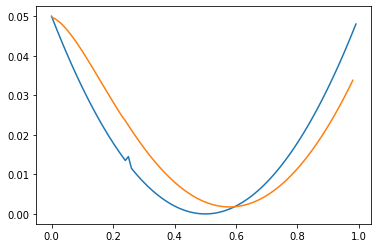

In [4]:
plt.plot(X, y, c='C0')
plt.plot(X[:-1], new_y, c='C1')

We can see that momentum smooths out our original parabola, but it also looks to have a “slow start”. It doesn't have the same shape. Rather, our momentum graph has more of a tail before getting to the dip, whereas the original parabola didn't. That tail is what I'm referring to when I mentioned a “slow start”. This occurs because, if you remember from our momentum lesson, at the beginning, the momentum equation doesn't have much (or any) past information to average out the smoothing. It get's better as it goes on, because there's much more "past" information to average out. This is why I referred to it as a “slow start”. The good news is that the bias correction equation helps quite a bit and gets rid of that tail at the beginning.

The denominator of the bias correction equation gets raised to the power of the iteration. Since the momentum (and RMSProp) value is a decimal between 0 and 1, the higher the power is, the smaller it gets. That means that as we move further with our iterations, the denominator moves closer to 1 (because 1 minus a very small number is essentially 1). Now, if we look at our momentum equation with the bias correction, we get something that now looks like this (putting it side-by-side with the original parabola):

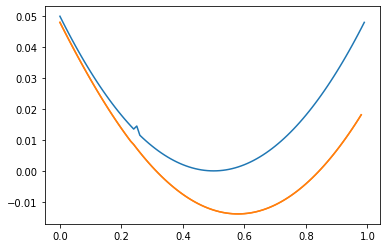

In [ ]:
new_y = []
velocity = 0

for i in range(len(X)-1):
    cur_grad = gradient(X[i], X[i+1], y[i], y[i+1])
    velocity = (momentum*velocity) + ((1-momentum)*cur_grad)
    velocity_corrected = velocity/(1-(momentum**(i+1)))
    if(not new_y):
        prev_y = y[0]
    else:
        prev_y = new_y[-1]
    new_y.append((velocity_corrected*(X[i+1]-X[i]))+prev_y)

plt.plot(X, y, c='C0')
plt.plot(X[:-1], new_y, c='C1')

Yes, the dip is bigger, but it no longer starts off slow. It doesn't have a tail at the beginning, rather, it gets right into it. This helps us optimize our equations even further.

*Note: the corrected momentum and RMSProp only take the original value places when multiplying by the learning rate, but do not replace the original momentum and RMSProp values for the next iteration. The uncorrected values will be used to update the equations in the next iteration.*

Hope that helps in making sense of the Adam optimizer.

## Adam Using PyTorch

The good news is that PyTorch has a ready to use Adam class which we can take advantage of, instead of reimplementing it in practice.
Let's take a look.

We'll use the same architecture and learning rate from above, but we won't have to set the momentum or RMSProp values. PyTorch uses the recommended 0.9 and 0.999 values which we used above.

In [ ]:
model = Model(dim).to(device)
bce = nn.BCELoss()
# we'll reuse the learning_rate from above
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Let's train our model with PyTorch's Adam optimizer and see how it stacks up against ours.

In [ ]:
epoch_loss = []
model.train()
for epoch in range(epochs+1):
    iteration_loss = 0.
    for i, data in enumerate(data_loader):
        X, y = data
        y_pred = model(X.float().to(device))
        loss = bce(y_pred.to(device), y.reshape(-1,1).float().to(device))
        iteration_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    epoch_loss.append(iteration_loss/(i+1))
    if(epoch % print_iter == 0):
        print('Train: epoch: {0} - loss: {1:.5f}'.format(epoch, epoch_loss[-1]))

Train: epoch: 0 - loss: 0.70853
Train: epoch: 20 - loss: 0.66472
Train: epoch: 40 - loss: 0.63899
Train: epoch: 60 - loss: 0.61415
Train: epoch: 80 - loss: 0.58931
Train: epoch: 100 - loss: 0.56417
Train: epoch: 120 - loss: 0.53942
Train: epoch: 140 - loss: 0.51637
Train: epoch: 160 - loss: 0.49089
Train: epoch: 180 - loss: 0.46984
Train: epoch: 200 - loss: 0.44524


It looks to be almost identical. We'll plot it out.

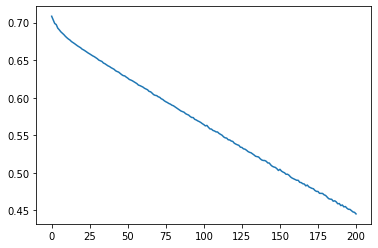

In [ ]:
plt.plot(epoch_loss)

Awesome! It looks identical. Congratulations, you just recreated PyTorch's Adam optimizer from scratch!

That's the end of this post. I understand that it may be a little tough to ingest the first time around, so go over it again. It took me quite a bit of time before I really understood it.